# GPU-accelerated Data Science Workflow

## Human Activity Recognition using GPU DataFrame and GPU KMeans

Analyzing smart phone sensors to determine the activity the person is engaged in.


- Activities: biking, sitting, standing, walking, stairup, stairdown.
- Sensors: Accelerometer and Gyroscope.
- Sampling rate: highest frequency the respective device allows.

Link to the dataset: http://archive.ics.uci.edu/ml/datasets/Heterogeneity+Activity+Recognition


Our approach uses KMeans from the `h2o4gpu` package to form the initial clusters.  Then, we use nearest neighbour to classify the clusters; i.e. the intra-cluster dominating class determines the class for the cluster.  During the classification, we choose the class of the closest cluster center.

The data is preprocessed with `pygdf` DataFrame.  Initially, each row in the dataset is a single event.  Our preprocessing bins the event into frames and transpose the events in each frame into columns for a single record.  We then perform wavelet transformation to convert the time-domain into time-frequency domain.  These are done with the help of custom CUDA kernels written with `numba`.


In [1]:
# This automatically time every cell's execution
!pip install ipython-autotime
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd

import pygdf

time: 591 ms



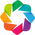

time: 1.1 s


In [3]:
import holoviews as hv
import bokeh.palettes

hv.extension('bokeh')

In [4]:
import logging
logging.disable(logging.WARNING)

time: 7.04 ms


## Load data from CSV

In [5]:
nrows = 10000000

time: 18.6 ms


In [6]:
def read_data(path):
    print('reading', path)
    # Read using pandas 
    df = pd.read_csv(path, nrows=nrows, index_col='Index')
    print('shape =', df.shape)
    return df

time: 14.6 ms


In [7]:
import os

if not os.path.exists('data/har/Activity recognition exp'):
    # Unzip data if not already there
    !unzip "data/har/Activity recognition exp.zip" -d data/har
    !ls data/har

time: 14 ms


In [8]:
!wc -l "data/har/Activity recognition exp/Phones_accelerometer.csv"

13062476 data/har/Activity recognition exp/Phones_accelerometer.csv
time: 662 ms


In [9]:
pa_df = read_data('data/har/Activity recognition exp/Phones_accelerometer.csv')
pg_df = read_data('data/har/Activity recognition exp/Phones_gyroscope.csv')

reading data/har/Activity recognition exp/Phones_accelerometer.csv
shape = (10000000, 9)
reading data/har/Activity recognition exp/Phones_gyroscope.csv
shape = (10000000, 9)
time: 21.2 s


Preprocess categorical columns

In [10]:
from collections import defaultdict

cats = defaultdict(set)
for df in [pa_df, pg_df]:
    for col in ['Model', 'User', 'Device', 'gt']:
        df[col] = df[col].astype('category')
        cats[col] |= set(df[col].astype('category').cat.categories)

for col in ['Model', 'User', 'Device', 'gt']:
    ordered_cats = sorted(cats[col])
    print(col, ordered_cats)
    for df in [pa_df, pg_df]:
        df[col].cat.set_categories(ordered_cats)

Model ['nexus4', 's3', 's3mini', 'samsungold']
User ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Device ['nexus4_1', 'nexus4_2', 's3_1', 's3_2', 's3mini_1', 's3mini_2', 'samsungold_1', 'samsungold_2']
gt ['bike', 'null', 'sit', 'stairsdown', 'stairsup', 'stand', 'walk']
time: 5.58 s


In [11]:
activities = tuple(df['gt'].cat.categories)
activities

('bike', 'null', 'sit', 'stairsdown', 'stairsup', 'stand', 'walk')

time: 3.28 ms


### Convert to GPU DataFrame

In [12]:
pa_df = pygdf.DataFrame.from_pandas(pa_df)
pg_df = pygdf.DataFrame.from_pandas(pg_df)

time: 480 ms


In [13]:
pa_df.dtypes

Arrival_Time        int64
Creation_Time       int64
x                 float64
y                 float64
z                 float64
User             category
Model            category
Device           category
gt               category
dtype: object

time: 4.1 ms


In [14]:
pa_df.head().to_pandas()

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,1424696633908,1424696631913248572,-5.958191,0.688065,8.135345,a,nexus4,nexus4_1,stand
1,1424696633909,1424696631918283972,-5.952240,0.670212,8.136536,a,nexus4,nexus4_1,stand
2,1424696633918,1424696631923288855,-5.995087,0.653549,8.204376,a,nexus4,nexus4_1,stand
3,1424696633919,1424696631928385290,-5.942718,0.676163,8.128204,a,nexus4,nexus4_1,stand
4,1424696633929,1424696631933420691,-5.991516,0.641647,8.135345,a,nexus4,nexus4_1,stand


time: 35.7 ms


In [15]:
pg_df.head().to_pandas()

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,1424696633909,1424696631914042029,0.013748,-0.000626,-0.023376,a,nexus4,nexus4_1,stand
1,1424696633909,1424696631919046912,0.014816,-0.001694,-0.022308,a,nexus4,nexus4_1,stand
2,1424696633918,1424696631924051794,0.015884,-0.001694,-0.021240,a,nexus4,nexus4_1,stand
3,1424696633919,1424696631929117712,0.016953,-0.003830,-0.020172,a,nexus4,nexus4_1,stand
4,1424696633928,1424696631934214148,0.015884,-0.007034,-0.020172,a,nexus4,nexus4_1,stand


time: 22.8 ms


## More preprocessing on the GPU

### Exclude `gt == null`

In [16]:
null_idx = pa_df['gt'].cat.categories.index('null')

time: 11.1 ms


In [17]:
print('before', len(pa_df), len(pg_df))
pa_df = pa_df.query('gt != @null_idx').reset_index()
pg_df = pg_df.query('gt != @null_idx').reset_index()
print('after', len(pa_df), len(pg_df))

before 10000000 10000000
after 8588137 8647248
time: 1.38 s


### Scale x, y, z

In [18]:
def rescale(sr):
    maxval = max(abs(sr.max()), abs(sr.min()))
    return sr / maxval

for df in [pa_df, pg_df]:
    for col in 'xyz':
        df[col] = rescale(df[col])

time: 124 ms


### Bin the time series

In [19]:
dt = 1280000000
subsample_size = 2**5
print('subsample_size', subsample_size)
dt2 = dt / subsample_size
pa_df['resampled'] = (pa_df['Creation_Time'] // dt)
pg_df['resampled'] = (pg_df['Creation_Time'] // dt)
pa_df['resampled_inner'] = (pa_df['Creation_Time'] // dt2)
pg_df['resampled_inner'] = (pg_df['Creation_Time'] // dt2)

subsample_size 32
time: 137 ms


### Use Numba to JIT compile GPU kernels for transposing rows into columns

In [20]:
from numba import cuda, float64


@cuda.jit
def is_valid(offsets, valid):
    idx = cuda.grid(1)
    if idx < valid.size:
        s = offsets[idx]
        e = offsets[idx + 1]
        valid[idx] = e - s == subsample_size

@cuda.jit
def expand_df(offsets, inp, out):
    blkid = cuda.blockIdx.x
    tid = cuda.threadIdx.x
    row_start = offsets[blkid]
    row_stop = offsets[blkid + 1]
    if tid < out.shape[0]:
        val = np.nan
        if row_stop - row_start == out.shape[0]:
            val = inp[row_start + tid]

        out[tid, blkid] = val

time: 18.4 ms


### JIT custom GPU kernels for simple wavelet decomposition

In [21]:
@cuda.jit(device=True)
def inner_haar_wavelet(arr):
    # assume pow-of-2 subsample_size
    stride = subsample_size // 2
    while stride:
        i = cuda.threadIdx.x
        if i < stride:
            even = arr[2 * i]
            odd = arr[2 * i + 1]
            c0 = (even + odd) / 2
            c1 = (even - odd) / 2
        cuda.syncthreads()
        if i < stride:
            arr[i] = c0
            arr[i + stride] = c1
        cuda.syncthreads()
        stride //= 2


@cuda.jit
def haar_wavelet(arr):
    sm_arr = cuda.shared.array((subsample_size,), dtype=float64)
    blkid = cuda.blockIdx.x
    i = cuda.threadIdx.x
    sm_arr[i] = arr[i, blkid]
    cuda.syncthreads()

    inner_haar_wavelet(sm_arr)

    arr[i, blkid] = sm_arr[i]

            

time: 70.6 ms


### Use GPU Groupby to resample and bin the time series data

In [22]:
def expand(src_df):
    # First groupby creates the frames. Each frame has 20 rows.
    groupkeys = ['resampled', 'User', 'Model', 'Device', 'gt', 'resampled_inner']
    df = src_df.loc[:, groupkeys + ['x', 'y', 'z']].groupby(groupkeys).mean()
    # Second groupby transpose the rows in each frame into columns
    grouped, segs = df.groupby(groupkeys[:-1]).as_df()
    numgroups = len(segs)
    d_offsets = cuda.to_device(np.hstack([segs.to_array(), len(grouped)]))

    d_valid = cuda.device_array(numgroups, dtype=np.bool_)
    d_xs = cuda.device_array((subsample_size, numgroups), dtype=np.float64)
    d_ys = cuda.device_array((subsample_size, numgroups), dtype=np.float64)
    d_zs = cuda.device_array((subsample_size, numgroups), dtype=np.float64)
    
    # Launch transposing CUDA kernel
    # Each row of x, y, z becomes columns
    expand_df[numgroups, subsample_size](d_offsets, grouped['x'].to_gpu_array(), d_xs)
    expand_df[numgroups, subsample_size](d_offsets, grouped['y'].to_gpu_array(), d_ys)
    expand_df[numgroups, subsample_size](d_offsets, grouped['z'].to_gpu_array(), d_zs)
    is_valid.forall(d_offsets.size - 1)(d_offsets, d_valid)
    
    # Use wavelet to decompose the time-domain data into time-frequency data
    haar_wavelet[numgroups, subsample_size](d_xs)
    haar_wavelet[numgroups, subsample_size](d_ys)
    haar_wavelet[numgroups, subsample_size](d_zs)
    
    # Creates the final resampled dataframe.
    # Now, each row is a frame.
    outdf = pygdf.DataFrame()
    outdf['resampled'] = grouped['resampled'].take(d_offsets[:-1], ignore_index=True)
    outdf['User'] = grouped['User'].take(d_offsets[:-1], ignore_index=True)
    outdf['Device'] = grouped['Device'].take(d_offsets[:-1], ignore_index=True)
    outdf['gt'] = grouped['gt'].take(d_offsets[:-1], ignore_index=True)
    outdf['valid'] = d_valid
    for colname, colvals in zip('xyz', [d_xs, d_ys, d_zs]):
        for i in range(subsample_size):
            fullcolname = '{}{}'.format(colname, i)
            sr = pygdf.Series(colvals[i])
            outdf[fullcolname] = rescale(sr)
    
    out = outdf.query("valid")
    out.drop_column("valid")
    return out
    

time: 134 ms


Resample the accelerometer data

In [23]:
newpadf = expand(pa_df)
print(len(newpadf))
newpadf.head().to_pandas()

50965


,resampled,User,Device,gt,x0,x1,x2,x3,x4,x5,...,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31
1,2509,f,s3mini_1,stand,-0.211510,0.018443,0.005508,0.006502,0.005133,0.004928,...,0.006838,-0.008815,0.008272,-0.011556,0.003515,-0.000139,-0.000837,0.000869,0.002179,0.003309
2,2510,f,s3mini_1,stand,-0.206505,-0.042594,-0.006993,0.050066,-0.004636,-0.012918,...,-0.004619,0.027250,-0.021037,0.012428,0.014304,-0.027554,-0.009956,0.003238,0.025183,-0.021093
3,2511,f,s3mini_1,stand,-0.236763,0.064581,0.032943,-0.004412,0.014135,0.005666,...,0.002242,0.000434,-0.001961,-0.003091,-0.001515,0.002281,-0.003544,-0.022529,0.044218,-0.024608
6,2514,f,s3mini_1,stand,-0.232541,0.023304,0.001779,-0.030144,0.013683,-0.002366,...,0.000091,-0.005409,0.008660,-0.005353,0.004970,-0.003432,0.004933,-0.005035,0.004318,-0.005273
7,2515,f,s3mini_1,stand,-0.227210,0.002491,0.001938,0.015708,-0.000216,-0.002938,...,0.002762,-0.003035,0.003840,-0.004668,0.000667,-0.001389,0.001834,-0.001283,0.002179,-0.002923


time: 2.92 s


Resample the gyroscope data

In [24]:
newpgdf = expand(pg_df)
print(len(newpgdf))
newpgdf.head().to_pandas()

34765


,resampled,User,Device,gt,x0,x1,x2,x3,x4,x5,...,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31
2,2510,f,s3mini_1,stand,-0.013886,0.008579,0.002248,-0.000740,-0.004271,0.024107,...,-0.018787,-0.000027,0.034893,0.002603,0.002221,0.017530,-0.033403,-0.006898,0.017391,0.015960
3,2511,f,s3mini_1,stand,-0.002620,0.024681,0.003762,-0.005266,0.009202,0.004650,...,-0.008995,-0.010565,0.000478,-0.000203,0.008271,0.002842,0.000105,-0.009877,0.022593,0.017162
6,2514,f,s3mini_1,stand,-0.004370,-0.008412,-0.008702,-0.001288,0.003174,-0.004260,...,-0.001925,-0.005675,0.010908,0.003009,-0.011890,-0.005992,0.010283,0.006760,-0.017937,-0.011778
7,2515,f,s3mini_1,stand,-0.010144,-0.005724,-0.002440,0.002862,-0.003551,0.001251,...,-0.003884,0.001027,-0.004848,0.000372,0.000431,-0.005992,-0.003078,0.003781,0.003526,-0.002091
8,2516,f,s3mini_1,stand,-0.010403,-0.001179,0.002021,0.000737,-0.000417,0.002039,...,-0.002855,0.006161,-0.001563,-0.003482,-0.001522,0.005992,0.001854,0.005225,-0.001408,-0.002860


time: 1.4 s


### Use Inner-Join to combine the accelerometer and gyroscope data on the GPU

In [25]:
joined = newpadf.set_index('resampled').join(newpgdf.set_index('resampled'), how='inner',
                                             lsuffix='_a', rsuffix='_g')
joined.head().to_pandas()

,User_a,Device_a,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,...,z22_g,z23_g,z24_g,z25_g,z26_g,z27_g,z28_g,z29_g,z30_g,z31_g
2510,f,s3mini_1,stand,-0.206505,-0.042594,-0.006993,0.050066,-0.004636,-0.012918,-0.032624,...,-0.018787,-0.000027,0.034893,0.002603,0.002221,0.017530,-0.033403,-0.006898,0.017391,0.015960
2511,f,s3mini_1,stand,-0.236763,0.064581,0.032943,-0.004412,0.014135,0.005666,0.006127,...,-0.008995,-0.010565,0.000478,-0.000203,0.008271,0.002842,0.000105,-0.009877,0.022593,0.017162
2514,f,s3mini_1,stand,-0.232541,0.023304,0.001779,-0.030144,0.013683,-0.002366,0.008133,...,-0.001925,-0.005675,0.010908,0.003009,-0.011890,-0.005992,0.010283,0.006760,-0.017937,-0.011778
2515,f,s3mini_1,stand,-0.227210,0.002491,0.001938,0.015708,-0.000216,-0.002938,0.002065,...,-0.003884,0.001027,-0.004848,0.000372,0.000431,-0.005992,-0.003078,0.003781,0.003526,-0.002091
2516,f,s3mini_1,stand,-0.245601,0.030838,0.012506,0.013522,0.002451,0.005145,0.008537,...,-0.002855,0.006161,-0.001563,-0.003482,-0.001522,0.005992,0.001854,0.005225,-0.001408,-0.002860


time: 2.27 s


### Filter the joined table.  Drop mismatching rows.

In [26]:
filtered = joined.query("User_a == User_g and gt_a == gt_g and Device_a == Device_g")
print(len(filtered))
filtered.head().to_pandas()

34679


,User_a,Device_a,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,...,z22_g,z23_g,z24_g,z25_g,z26_g,z27_g,z28_g,z29_g,z30_g,z31_g
2510,f,s3mini_1,stand,-0.206505,-0.042594,-0.006993,0.050066,-0.004636,-0.012918,-0.032624,...,-0.018787,-0.000027,0.034893,0.002603,0.002221,0.017530,-0.033403,-0.006898,0.017391,0.015960
2511,f,s3mini_1,stand,-0.236763,0.064581,0.032943,-0.004412,0.014135,0.005666,0.006127,...,-0.008995,-0.010565,0.000478,-0.000203,0.008271,0.002842,0.000105,-0.009877,0.022593,0.017162
2514,f,s3mini_1,stand,-0.232541,0.023304,0.001779,-0.030144,0.013683,-0.002366,0.008133,...,-0.001925,-0.005675,0.010908,0.003009,-0.011890,-0.005992,0.010283,0.006760,-0.017937,-0.011778
2515,f,s3mini_1,stand,-0.227210,0.002491,0.001938,0.015708,-0.000216,-0.002938,0.002065,...,-0.003884,0.001027,-0.004848,0.000372,0.000431,-0.005992,-0.003078,0.003781,0.003526,-0.002091
2516,f,s3mini_1,stand,-0.245601,0.030838,0.012506,0.013522,0.002451,0.005145,0.008537,...,-0.002855,0.006161,-0.001563,-0.003482,-0.001522,0.005992,0.001854,0.005225,-0.001408,-0.002860


time: 1.75 s


### Create features table for KMeans

In [27]:
feature_columns = ['gt_a'] + [k for k in filtered.columns if k[0] in 'xyz']
features_df = filtered.loc[:, feature_columns]
print(len(features_df))
features_df.head().to_pandas()

34679


,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,x7_a,x8_a,...,z22_g,z23_g,z24_g,z25_g,z26_g,z27_g,z28_g,z29_g,z30_g,z31_g
2510,stand,-0.206505,-0.042594,-0.006993,0.050066,-0.004636,-0.012918,-0.032624,-0.011561,0.003516,...,-0.018787,-0.000027,0.034893,0.002603,0.002221,0.017530,-0.033403,-0.006898,0.017391,0.015960
2511,stand,-0.236763,0.064581,0.032943,-0.004412,0.014135,0.005666,0.006127,-0.006989,-0.001699,...,-0.008995,-0.010565,0.000478,-0.000203,0.008271,0.002842,0.000105,-0.009877,0.022593,0.017162
2514,stand,-0.232541,0.023304,0.001779,-0.030144,0.013683,-0.002366,0.008133,0.004576,0.003072,...,-0.001925,-0.005675,0.010908,0.003009,-0.011890,-0.005992,0.010283,0.006760,-0.017937,-0.011778
2515,stand,-0.227210,0.002491,0.001938,0.015708,-0.000216,-0.002938,0.002065,0.001390,-0.001097,...,-0.003884,0.001027,-0.004848,0.000372,0.000431,-0.005992,-0.003078,0.003781,0.003526,-0.002091
2516,stand,-0.245601,0.030838,0.012506,0.013522,0.002451,0.005145,0.008537,0.004583,0.001091,...,-0.002855,0.006161,-0.001563,-0.003482,-0.001522,0.005992,0.001854,0.005225,-0.001408,-0.002860


time: 651 ms


### Randomize data and split into training and testing

In [28]:
def split_train_test(df):
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    d_idx = cuda.to_device(idx)
    outdf = pygdf.DataFrame()
    for k in df.columns:
        outdf[k] = df[k].take(d_idx, ignore_index=True) 
        
    split_pt = int(len(outdf) * 0.8)
    return outdf[:split_pt], outdf[split_pt:]
    
train_df, test_df = split_train_test(features_df)
print('train size', len(train_df))
print('test size', len(test_df))

train_df.head().to_pandas()

train size 27743
test size 6936


,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,x7_a,x8_a,...,z22_g,z23_g,z24_g,z25_g,z26_g,z27_g,z28_g,z29_g,z30_g,z31_g
0,sit,0.813115,-0.008308,-0.023045,0.030992,-0.004353,0.011984,-0.004280,0.006111,0.005894,...,0.003075,0.002605,-0.003015,-0.001164,0.005177,0.003193,-0.007181,0.004963,-0.002627,-0.002001
1,walk,0.572051,-0.076391,0.221705,-0.080056,0.125159,-0.218939,0.474991,-0.273099,-0.270294,...,0.106285,0.238006,-0.284343,-0.162948,0.010052,0.193104,0.027143,0.002658,-0.001294,0.088839
2,stairsup,-0.429100,-0.051490,-0.004934,0.088639,-0.018973,-0.042550,0.207455,-0.115744,-0.013671,...,-0.091747,0.053854,-0.074762,-0.033164,-0.070650,0.104153,0.049318,-0.039141,-0.076777,-0.002620
3,stand,-0.102202,-0.028169,-0.008678,0.009011,0.001170,-0.003647,-0.003544,0.000862,-0.004688,...,-0.008498,0.005463,-0.004472,-0.016294,-0.000755,-0.001072,0.003153,-0.010027,0.004840,0.009930
4,stairsdown,-0.332416,-0.093524,-0.176072,0.190045,-0.155924,0.389804,-0.260187,-0.086947,0.174522,...,-0.119233,-0.267589,-0.149407,-0.237987,-0.237883,0.478903,-0.048695,-0.037242,-0.171837,0.064348


time: 331 ms


### Create feature matrix

In [29]:
feature_columns = [k for k in train_df.columns if k !='gt_a']
feature_matrix = train_df.as_matrix(feature_columns)

feature_matrix.shape

(27743, 192)

time: 62.9 ms


## GPU Machine Learning with H2O

### Use `h2o4gpu.KMeans` to cluster the data

In [30]:
import h2o4gpu

kmeans = h2o4gpu.KMeans(n_clusters=80, n_gpus=1, max_iter=1000)
kmeans.fit(feature_matrix)
predicted = kmeans.predict(feature_matrix)

time: 1.16 s


### Find meaning for each cluster

For each cluster, the dominating class is adopted as the class for the cluster.

In [31]:
pred_df = pygdf.DataFrame()

gt_predicted = pygdf.Series(np.asarray(predicted, dtype=np.int32))
pred_df['gt_predicted'] = gt_predicted.set_index(train_df.index)

for k in features_df.columns:
    pred_df[k] = train_df[k]

pred_df.head().to_pandas()

,gt_predicted,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,x7_a,...,z22_g,z23_g,z24_g,z25_g,z26_g,z27_g,z28_g,z29_g,z30_g,z31_g
0,0,sit,0.813115,-0.008308,-0.023045,0.030992,-0.004353,0.011984,-0.004280,0.006111,...,0.003075,0.002605,-0.003015,-0.001164,0.005177,0.003193,-0.007181,0.004963,-0.002627,-0.002001
1,29,walk,0.572051,-0.076391,0.221705,-0.080056,0.125159,-0.218939,0.474991,-0.273099,...,0.106285,0.238006,-0.284343,-0.162948,0.010052,0.193104,0.027143,0.002658,-0.001294,0.088839
2,64,stairsup,-0.429100,-0.051490,-0.004934,0.088639,-0.018973,-0.042550,0.207455,-0.115744,...,-0.091747,0.053854,-0.074762,-0.033164,-0.070650,0.104153,0.049318,-0.039141,-0.076777,-0.002620
3,44,stand,-0.102202,-0.028169,-0.008678,0.009011,0.001170,-0.003647,-0.003544,0.000862,...,-0.008498,0.005463,-0.004472,-0.016294,-0.000755,-0.001072,0.003153,-0.010027,0.004840,0.009930
4,17,stairsdown,-0.332416,-0.093524,-0.176072,0.190045,-0.155924,0.389804,-0.260187,-0.086947,...,-0.119233,-0.267589,-0.149407,-0.237987,-0.237883,0.478903,-0.048695,-0.037242,-0.171837,0.064348


time: 240 ms


One-hot encode the "activities" (`gt_a` column).  The will serve as "vote" to determine the class for each cluster.

In [32]:
out_df = pred_df.copy()
for name, col in zip(activities, 
                     pred_df['gt_a'].astype(np.int32).one_hot_encoding(cats=list(range(len(activities))))):
    out_df[name] = col.set_index(pred_df.index)
    
out_df.head().to_pandas()

,gt_predicted,gt_a,x0_a,x1_a,x2_a,x3_a,x4_a,x5_a,x6_a,x7_a,...,z29_g,z30_g,z31_g,bike,null,sit,stairsdown,stairsup,stand,walk
0,0,sit,0.813115,-0.008308,-0.023045,0.030992,-0.004353,0.011984,-0.004280,0.006111,...,0.004963,-0.002627,-0.002001,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,29,walk,0.572051,-0.076391,0.221705,-0.080056,0.125159,-0.218939,0.474991,-0.273099,...,0.002658,-0.001294,0.088839,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,64,stairsup,-0.429100,-0.051490,-0.004934,0.088639,-0.018973,-0.042550,0.207455,-0.115744,...,-0.039141,-0.076777,-0.002620,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44,stand,-0.102202,-0.028169,-0.008678,0.009011,0.001170,-0.003647,-0.003544,0.000862,...,-0.010027,0.004840,0.009930,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,17,stairsdown,-0.332416,-0.093524,-0.176072,0.190045,-0.155924,0.389804,-0.260187,-0.086947,...,-0.037242,-0.171837,0.064348,0.0,0.0,0.0,1.0,0.0,0.0,0.0


time: 242 ms


Count the "vote" for each cluster using groupby-mean

In [33]:
cols = [k for k in out_df.columns if k.startswith('gt') and k !='gt_a' or k in activities]
finaldf = out_df.loc[:, cols].groupby('gt_predicted').mean()
finaldf.head().to_pandas()

,gt_predicted,bike,null,sit,stairsdown,stairsup,stand,walk
0,0,0.037807,0.0,0.883826,0.008262,0.003756,0.062594,0.003756
1,1,0.000000,0.0,0.000000,0.959459,0.040541,0.000000,0.000000
2,2,0.021459,0.0,0.000000,0.223176,0.643777,0.000000,0.111588
3,3,0.005540,0.0,0.000000,0.038781,0.947368,0.000000,0.008310
4,4,0.905325,0.0,0.000000,0.000000,0.094675,0.000000,0.000000


time: 419 ms


Associate each cluster with the dominating activity.

In [34]:
from collections import defaultdict

predict_dict = {}
for row in range(len(finaldf)):
    r = finaldf.gt_predicted[row]
    best = max((finaldf[k][row], k) for k in activities)
    print('cluster {}: {:.1f}% {}'.format(r,
                                          best[0] * 100, 
                                          best[1]))
    predict_dict[r] = "{}.{}".format(best[1], r)
    
predict_cats = [predict_dict.get(i, 'unknown.{}'.format(i)) for i in range(len(kmeans.cluster_centers_))]

cluster 0: 88.4% sit
cluster 1: 95.9% stairsdown
cluster 2: 64.4% stairsup
cluster 3: 94.7% stairsup
cluster 4: 90.5% bike
cluster 5: 95.3% walk
cluster 6: 87.9% stand
cluster 7: 88.1% stairsdown
cluster 8: 96.6% stairsup
cluster 9: 95.4% stairsup
cluster 10: 76.2% bike
cluster 11: 97.2% walk
cluster 12: 58.4% stand
cluster 13: 96.3% stairsup
cluster 14: 64.8% stairsup
cluster 15: 96.7% walk
cluster 16: 87.5% stairsdown
cluster 17: 93.4% stairsdown
cluster 18: 93.9% walk
cluster 19: 86.6% walk
cluster 20: 79.6% walk
cluster 21: 96.7% bike
cluster 22: 90.7% stairsup
cluster 23: 88.3% bike
cluster 24: 75.1% walk
cluster 25: 95.9% stairsdown
cluster 26: 93.7% stairsup
cluster 27: 79.4% walk
cluster 28: 85.5% bike
cluster 29: 48.1% walk
cluster 30: 93.9% stairsdown
cluster 31: 91.6% stairsup
cluster 32: 100.0% stairsup
cluster 33: 99.0% bike
cluster 34: 96.2% bike
cluster 35: 47.8% walk
cluster 36: 92.2% stairsup
cluster 37: 44.1% stairsup
cluster 38: 96.7% walk
cluster 39: 49.1% stairsdow

### Evaluate the model with the testing dataset

In [35]:
test_matrix = test_df.as_matrix(feature_columns)
test_matrix.shape

(6936, 192)

time: 60.7 ms


In [36]:
predict_test = kmeans.predict(test_matrix)

time: 15.4 ms


In [37]:
eval_df = pygdf.DataFrame()

eval_df['gt_predicted'] = pd.Categorical.from_codes(predict_test, categories=predict_cats)
eval_df['gt_a'] = test_df['gt_a'].reset_index()

eval_df.head(n=30).to_pandas()

,gt_predicted,gt_a
0,stand.6,stairsup
1,bike.21,bike
2,walk.50,walk
3,sit.0,sit
4,sit.76,sit
5,stairsup.8,stairsup
6,stand.6,stand
7,stairsup.3,stairsup
8,stand.6,bike
9,stand.44,stand


time: 22 ms


Compute prediction accuracy

In [38]:
matches = eval_df.to_pandas().apply(lambda sr: sr['gt_predicted'].split('.')[0] == sr['gt_a'], axis=1)
num_correct = len(matches[matches == True])
num_total = len(matches)
print('{:.1f}% correctly predicted'.format(100 * num_correct / num_total))

82.1% correctly predicted
time: 170 ms


### Visualize the clusters

Use LDA to 2D-project our training data

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda_feat_mat = lda.fit(feature_matrix, train_df['gt_a'].to_array()).transform(feature_matrix)

time: 395 ms


In [40]:
cluster_df = pygdf.DataFrame()
cluster_df['x'] = np.require(lda_feat_mat[:, 0], requirements='C')
cluster_df['y'] = np.require(lda_feat_mat[:, 1], requirements='C')
cluster_df['activity'] = pred_df['gt_a']

predicted_clusters = pd.Categorical.from_codes(pred_df['gt_predicted'].to_pandas(), categories=predict_cats)
cluster_df['prediction'] = pd.Categorical([k.split('.')[0] for k in predicted_clusters])

cluster_df.head().to_pandas()

,x,y,activity,prediction
0,-3.188303,-1.248258,sit,sit
1,-2.335307,-0.333009,walk,walk
2,0.933199,-1.020756,stairsup,bike
3,-0.272932,0.763098,stand,stand
4,0.365401,0.425945,stairsdown,stairsdown


time: 45.7 ms


In [41]:
%%opts Points [width=480, height=400]

plot_df = cluster_df.to_pandas().sample(min(2000, len(cluster_df)))

cmap = bokeh.palettes.Set1[8]

pts_expected = {k : hv.Points(plot_df.loc[plot_df['activity'] == k])(style={'color': col}) 
                for k, col in zip(activities, cmap)}

pts_predicted = {k : hv.Points(plot_df.loc[plot_df['prediction'] == k])(style={'color': col}) 
                for k, col in zip(activities, cmap)}

left = hv.NdOverlay(pts_expected, kdims=['activity'])
right = hv.NdOverlay(pts_predicted, kdims=['activity'])

left.relabel('Expected') + right.relabel('Predicted')

:Layout
   .NdOverlay.Expected  :NdOverlay   [activity]
      :Points   [x,y]   (activity,prediction)
   .NdOverlay.Predicted :NdOverlay   [activity]
      :Points   [x,y]   (activity,prediction)

time: 828 ms
time: 828 ms


### Search for best k in k-means

In [42]:
def eval_cluster_size(n_clusters, test_df):
    # Clustering
    kmeans = h2o4gpu.KMeans(n_clusters=n_clusters, n_gpus=1, max_iter=1000)
    kmeans.fit(feature_matrix)
    predicted = kmeans.predict(feature_matrix)

    # Determine cluster meaning
    pred_df = pygdf.DataFrame()

    gt_predicted = pygdf.Series(np.asarray(predicted, dtype=np.int32))
    pred_df['gt_predicted'] = gt_predicted.set_index(train_df.index)

    for k in features_df.columns:
        pred_df[k] = train_df[k]

    out_df = pred_df.copy()
    for name, col in zip(activities, 
                         pred_df['gt_a'].astype(np.int32).one_hot_encoding(cats=list(range(len(activities))))):
        out_df[name] = col.set_index(pred_df.index)


    cols = [k for k in out_df.columns if k.startswith('gt') and k !='gt_a' or k in activities]
    finaldf = out_df.loc[:, cols].groupby('gt_predicted').mean()


    predict_dict = {}
    for row in range(len(finaldf)):
        r = finaldf.gt_predicted[row]
        best = max((finaldf[k][row], k) for k in activities)
        predict_dict[r] = "{}.{}".format(best[1], r)

    predict_cats = [predict_dict.get(i, 'unknown.{}'.format(i)) for i in range(len(kmeans.cluster_centers_))]

    # Evaluate
    test_matrix = test_df.as_matrix(feature_columns)

    predict_test = kmeans.predict(test_matrix)

    eval_df = pygdf.DataFrame()

    eval_df['gt_predicted'] = pd.Categorical.from_codes(predict_test, categories=predict_cats)
    eval_df['gt_a'] = test_df['gt_a'].reset_index()

    eval_df.head(n=30).to_pandas()

    matches = eval_df.to_pandas().apply(lambda sr: sr['gt_predicted'].split('.')[0] == sr['gt_a'], axis=1)
    num_correct = len(matches[matches == True])
    num_total = len(matches)
    correctness = num_correct / num_total
    print('n_clusters={} | {:.1f}% correctly predicted'.format(n_clusters, 100 * correctness))
    return correctness
    

print("Scan testing data")
cc_test = [(k, eval_cluster_size(k, test_df=test_df)) for k in range(10, 500, 50)]
print("Scan training data")
cc_train = [(k, eval_cluster_size(k, test_df=train_df)) for k in range(10, 500, 50)]

Scan testing data
n_clusters=10 | 52.6% correctly predicted
n_clusters=60 | 81.5% correctly predicted
n_clusters=110 | 83.3% correctly predicted
n_clusters=160 | 86.6% correctly predicted
n_clusters=210 | 87.4% correctly predicted
n_clusters=260 | 89.4% correctly predicted
n_clusters=310 | 89.9% correctly predicted
n_clusters=360 | 89.2% correctly predicted
n_clusters=410 | 90.2% correctly predicted
n_clusters=460 | 91.3% correctly predicted
Scan training data
n_clusters=10 | 51.5% correctly predicted
n_clusters=60 | 80.9% correctly predicted
n_clusters=110 | 85.2% correctly predicted
n_clusters=160 | 87.8% correctly predicted
n_clusters=210 | 87.9% correctly predicted
n_clusters=260 | 90.1% correctly predicted
n_clusters=310 | 91.2% correctly predicted
n_clusters=360 | 91.1% correctly predicted
n_clusters=410 | 91.5% correctly predicted
n_clusters=460 | 92.3% correctly predicted
time: 30.3 s


Plot accuracy vs num of clusters

In [43]:
%%opts Curve [width=500, height=400, show_grid=True]


def cc_make_df(cc):
    xs, ys = zip(*cc)
    df = pd.DataFrame()
    df['num_cluster'] = xs
    df['accuracy %'] = np.asarray(ys) * 100
    return df


df_test = cc_make_df(cc_test)
df_train = cc_make_df(cc_train)

title = 'Accuracy vs Number of Clusters'
(hv.Scatter(df_test) * hv.Curve(df_test, label='test') * hv.Scatter(df_train) * hv.Curve(df_train, label='train')).relabel(title)

:Overlay
   .Scatter.I   :Scatter   [num_cluster]   (accuracy %)
   .Curve.Test  :Curve   [num_cluster]   (accuracy %)
   .Scatter.II  :Scatter   [num_cluster]   (accuracy %)
   .Curve.Train :Curve   [num_cluster]   (accuracy %)

time: 160 ms
time: 160 ms
